These notebook is dedicated to study the effect of the data set size on the model accuracy. The goal is to obtain a rough estimate of the minimum set size to use with feed-forward networks

In [23]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import DataStructs
from itertools import product
from sklearn.metrics import confusion_matrix
from tensorboard.plugins.hparams import api as hp
from sklearn.model_selection import train_test_split
matplotlib.rcParams.update({'font.size': 24})
plt.style.use("ggplot")
PATH_DATA = "../datasets/CYP/"

In [24]:
shared_data = pd.read_csv(os.path.join(PATH_DATA, "shared_set_cyp.csv"))
labels_3a4 = (shared_data["p450-cyp3a4 Activity Outcome"] == "Active").values.astype(int)
validation_3a4_data = pd.read_csv(os.path.join(PATH_DATA, "only_3a4_set_cyp.csv"))
labels_validation_3a4 = (validation_3a4_data["p450-cyp3a4 Activity Outcome"] == "Active").values.astype(int)

In [25]:
def get_features(input_sdf):
    structures_shared = Chem.SDMolSupplier(input_sdf)
    features = []
    for mol in structures_shared:
        fp = AllChem.GetMorganFingerprintAsBitVect(mol,2,nBits=1024)
        arr = np.zeros((0,), dtype=np.int8)
        DataStructs.ConvertToNumpyArray(fp,arr)
        features.append(arr)
    return np.array(features)

In [26]:
if os.path.exists("shared_set_features.npy"):
    features_shared = np.load("shared_set_features.npy")
else:
    features_shared = get_features(os.path.join(PATH_DATA, "shared_set_cyp.sdf"))
    np.save("shared_set_features.npy", features_shared)
if os.path.exists("only_3a4_set_features.npy"):
    features_only_3a4 = np.load("only_3a4_set_features.npy")
else:   
    features_only_3a4 = get_features(os.path.join(PATH_DATA, "only_3a4_set_cyp.sdf"))
    np.save("only_3a4_set_features.npy", features_only_3a4)

In [27]:
def print_metrics(predicted_values, target_values):
    tn, fp, fn, tp = confusion_matrix(target_values, predicted_values >= 0.5).ravel()
    Sn = tp/(tp+fn)
    Sp = tn/(tn+fp)
    precision = tp/(tp+fp)
    ner = (Sn+Sp)/2
    accuracy = (tp+tn)/(tp+tn+fp+fn)
    mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
    print(f"NER: {ner:.3f}, Sensitivity or recall: {Sn:.3f}, Specificity: {Sp:.3f}, Precision: {precision:.3f}, Correctly classified: {accuracy:.3f}, MCC: {mcc:.3f}")
    return [ner, Sn, Sp, precision, accuracy, mcc]

In [28]:
def plot_confusion(predicted_values, target_values, plot_file=None):
    cm = confusion_matrix(target_values, predicted_values >= 0.5)
    f,ax = plt.subplots()
    sns.heatmap(cm, annot=True, ax = ax, fmt="g", cmap="Greens")
    # labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(['Inactive', 'Active']); ax.yaxis.set_ticklabels(['Inactive', 'Active'])
    if plot_file is not None:
        f.savefig(plot_file, dpi=300)

In [29]:
plots_path = os.path.join("confusion_matrix_plots", "3a4")
os.makedirs(plots_path, exist_ok=True)
plots_path_balanced = os.path.join("confusion_matrix_plots_balanced", "3a4")
os.makedirs(plots_path_balanced, exist_ok=True)

In [30]:
sizes = [100, 300, 500, 800, 1000, 2000, 3000, 5000, 7000, 9420]
hidden_layers = 8
neurons = 256
dropout = 0.2
lr = 0.1
opt  = tf.keras.optimizers.SGD(lr=lr)
L2 = 0.0010000

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(1024, activation='relu', input_shape=(1024,)),tf.keras.layers.Dropout(dropout)]+
    [tf.keras.layers.Dense(neurons, kernel_regularizer=tf.keras.regularizers.l2(L2),  activation="relu") for _ in range(hidden_layers)]+
    [tf.keras.layers.Dense(1, activation="sigmoid")])

loss_function = tf.keras.losses.BinaryCrossentropy()
model.compile(optimizer=opt, loss=loss_function, metrics=tf.keras.metrics.BinaryAccuracy(name="binary_accuracy"))
# columns are: NER, Sensitivity, Specificity, Precision, accuracy, MCC
results_test = []
results_validation = []
active_indices = np.where(labels_3a4 == 1)[0]
active_fraction = len(active_indices)/len(labels_3a4)
inactive_indices = np.where(labels_3a4 == 0)[0]
for size in sizes:
    n_actives = int(active_fraction*size)
    n_inactives = size-n_actives
    selected_active = np.random.choice(active_indices, size=n_actives, replace=False)
    selected_inactive = np.random.choice(inactive_indices, size=n_inactives, replace=False)
    selected = np.sort(selected_active.tolist()+selected_inactive.tolist())
    train_data, test_data, train_labels, test_labels = train_test_split(features_shared[selected], labels_3a4[selected], stratify=labels_3a4[selected])
    history = model.fit(train_data, train_labels, epochs=10, verbose=0)
    predictions = model.predict(test_data)
    print(f"Metrics with size {size}, testing set")
    res_test = print_metrics(predictions, test_labels);
    results_test.append(res_test)
    plot_confusion(predictions, test_labels, os.path.join(plots_path, f"confusion_test_set_size_{size}_3a4.png"))
    print(f"Metrics with size {size}, validation set")
    predictions = model.predict(features_only_3a4)
    res_validation = print_metrics(predictions, labels_validation_3a4);
    results_validation.append(res_validation)
    plot_confusion(predictions, labels_validation_3a4, os.path.join(plots_path, f"confusion_validation_set_size_{size}_3a4.png"));

Metrics with size 100, testing set
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.640, MCC: nan


<ipython-input-27-e0a4f165b1ff>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-27-e0a4f165b1ff>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


Metrics with size 100, validation set
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.510, MCC: nan
Metrics with size 300, testing set
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.387, Correctly classified: 0.387, MCC: nan


<ipython-input-27-e0a4f165b1ff>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


Metrics with size 300, validation set
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.490, Correctly classified: 0.490, MCC: nan
Metrics with size 500, testing set
NER: 0.733, Sensitivity or recall: 0.792, Specificity: 0.675, Precision: 0.603, Correctly classified: 0.720, MCC: 0.454
Metrics with size 500, validation set
NER: 0.650, Sensitivity or recall: 0.813, Specificity: 0.487, Precision: 0.604, Correctly classified: 0.647, MCC: 0.317
Metrics with size 800, testing set
NER: 0.776, Sensitivity or recall: 0.935, Specificity: 0.618, Precision: 0.605, Correctly classified: 0.740, MCC: 0.548
Metrics with size 800, validation set
NER: 0.655, Sensitivity or recall: 0.864, Specificity: 0.446, Precision: 0.600, Correctly classified: 0.651, MCC: 0.339
Metrics with size 1000, testing set
NER: 0.800, Sensitivity or recall: 0.763, Specificity: 0.837, Precision: 0.747, Correctly classified: 0.808, MCC: 0.597
Metrics with size 1000, validation set
NER: 0.688, Sensitivity

<ipython-input-31-a8b65bb2d055>:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f, ax = plt.subplots(figsize=(10,10))
<ipython-input-31-a8b65bb2d055>:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f, ax = plt.subplots(figsize=(10,10))


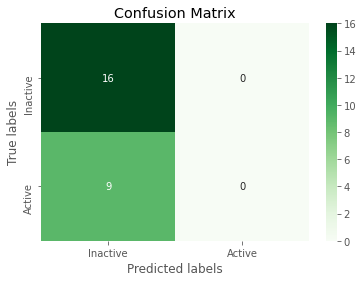

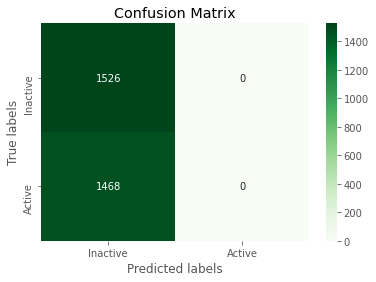

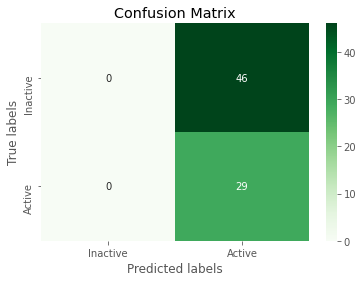

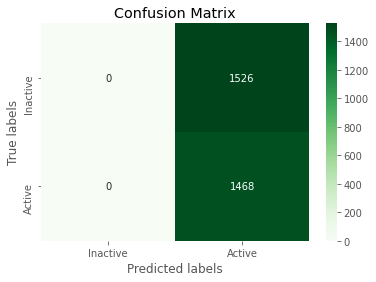

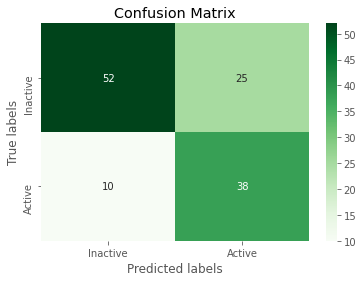

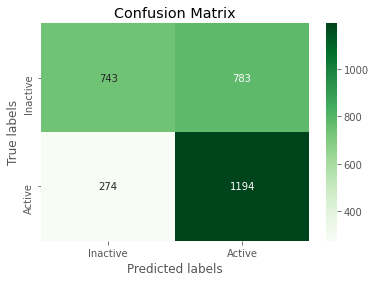

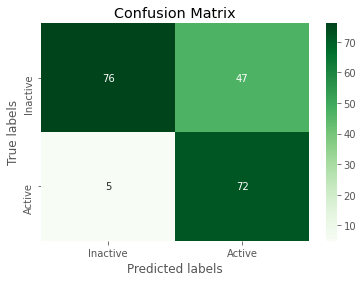

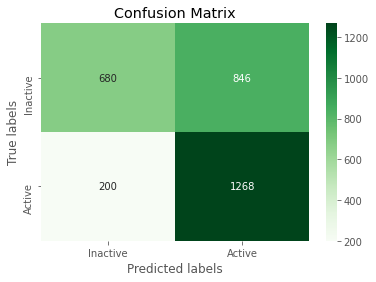

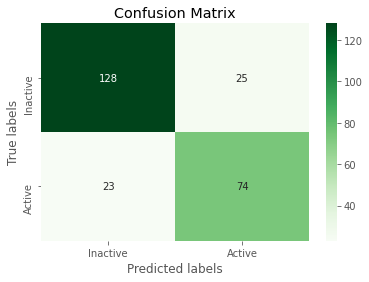

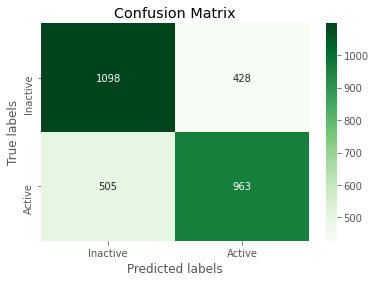

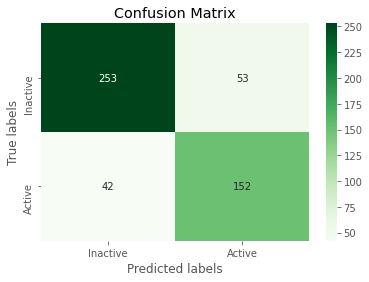

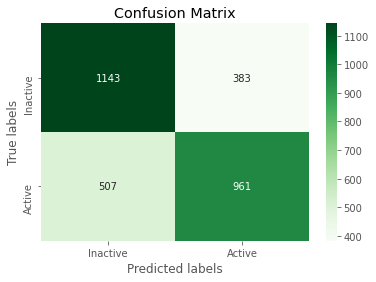

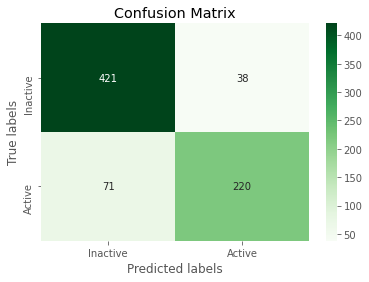

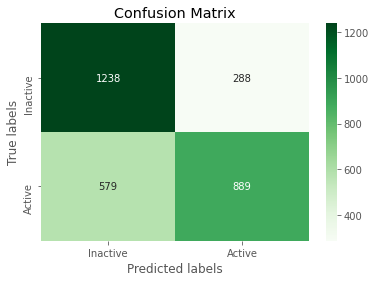

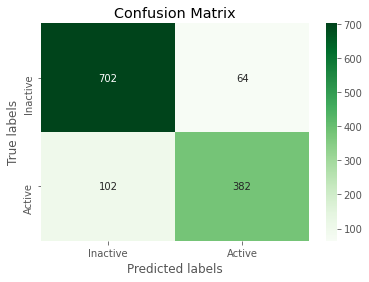

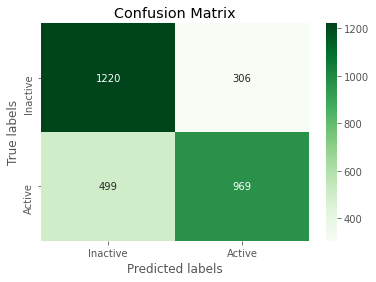

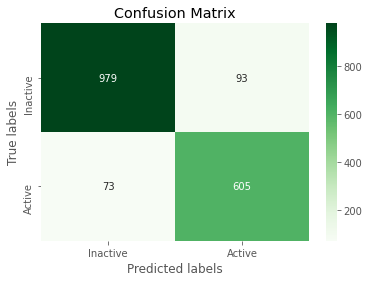

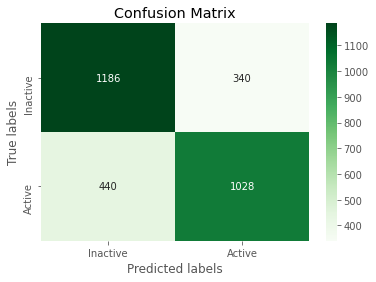

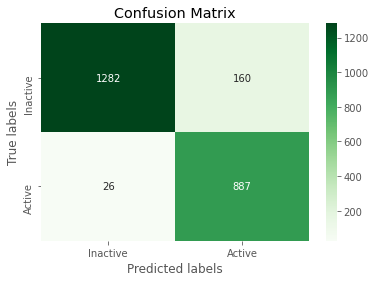

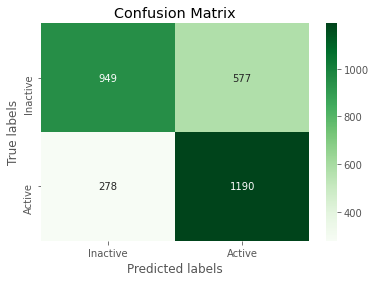

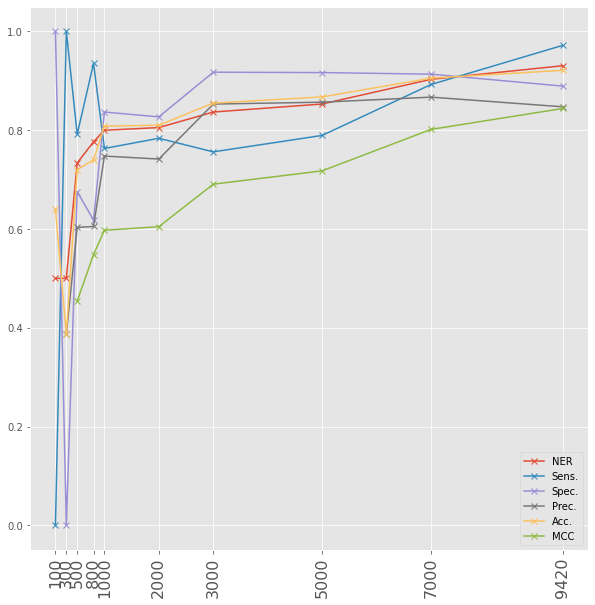

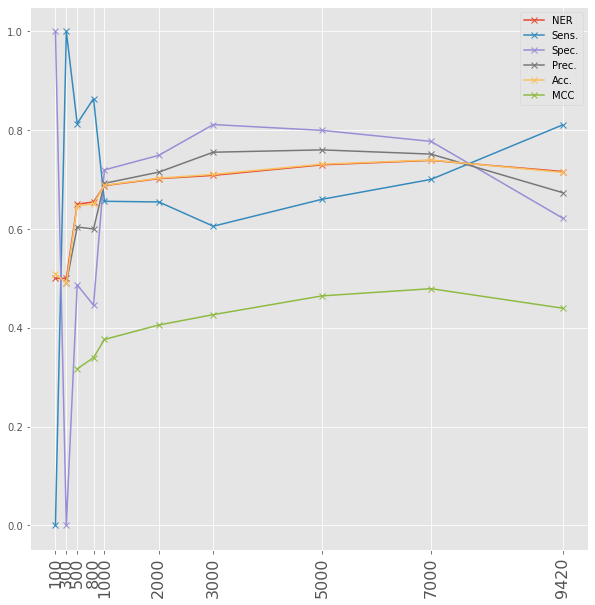

In [31]:
results_test = np.array(results_test)
results_validation = np.array(results_validation)
labels = ["NER", "Sens.", "Spec.", "Prec.", "Acc.", "MCC"]
f, ax = plt.subplots(figsize=(10,10))
lines = ax.plot(sizes, results_test, "x-")
ax.legend(lines, labels)
ax.set_xticks(ticks=sizes)
ax.set_xticklabels(sizes, rotation=90, fontsize=16);
f.savefig(os.path.join(plots_path, "metrics_test_evolution_3a4.png"), bbox_inches="tight", dpi=300)
f, ax = plt.subplots(figsize=(10,10))
lines = ax.plot(sizes, results_validation, "x-")
ax.legend(lines, labels)
ax.set_xticks(ticks=sizes)
ax.set_xticklabels(sizes, rotation=90, fontsize=16);
f.savefig(os.path.join(plots_path, "metrics_validation_evolution_3a4.png"), bbox_inches="tight", dpi=300)

In [32]:
sizes = [100, 300, 500, 800, 1000, 2000, 3000, 5000, 7000, 9420]
hidden_layers = 8
neurons = 256
dropout = 0.2
lr = 0.1
opt  = tf.keras.optimizers.SGD(lr=lr)
L2 = 0.0010000

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(1024, activation='relu', input_shape=(1024,)),tf.keras.layers.Dropout(dropout)]+
    [tf.keras.layers.Dense(neurons, kernel_regularizer=tf.keras.regularizers.l2(L2),  activation="relu") for _ in range(hidden_layers)]+
    [tf.keras.layers.Dense(1, activation="sigmoid")])

loss_function = tf.keras.losses.BinaryCrossentropy()
model.compile(optimizer=opt, loss=loss_function, metrics=tf.keras.metrics.BinaryAccuracy(name="binary_accuracy"))
# columns are: NER, Sensitivity, Specificity, Precision, accuracy, MCC
results_test = []
results_validation = []
active_indices = np.where(labels_3a4 == 1)[0]
active_fraction = 0.5
inactive_indices = np.where(labels_3a4 == 0)[0]
for size in sizes:
    n_actives = int(active_fraction*size)
    if n_actives > len(active_indices):
        n_actives = len(active_indices)
    n_inactives = size-n_actives
    selected_active = np.random.choice(active_indices, size=n_actives, replace=False)
    selected_inactive = np.random.choice(inactive_indices, size=n_inactives, replace=False)
    selected = np.sort(selected_active.tolist()+selected_inactive.tolist())
    train_data, test_data, train_labels, test_labels = train_test_split(features_shared[selected], labels_3a4[selected], stratify=labels_3a4[selected])
    print("Proportion actives in test:", np.sum(test_labels)/len(test_labels), "Proportion actives in train:", np.sum(train_labels)/len(train_labels))
    history = model.fit(train_data, train_labels, epochs=10, verbose=0)
    predictions = model.predict(test_data)
    print(f"Metrics with size {size}, testing set")
    res_test = print_metrics(predictions, test_labels);
    results_test.append(res_test)
    plot_confusion(predictions, test_labels, os.path.join(plots_path_balanced, f"confusion_test_set_size_{size}_balanced_3a4.png"))
    print(f"Metrics with size {size}, validation set")
    predictions = model.predict(features_only_3a4)
    res_validation = print_metrics(predictions, labels_validation_3a4);
    results_validation.append(res_validation)
    plot_confusion(predictions, labels_validation_3a4, os.path.join(plots_path_balanced, f"confusion_validation_set_size_{size}_balanced_3a4.png"));

Proportion actives in test: 0.48 Proportion actives in train: 0.5066666666666667
Metrics with size 100, testing set
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.480, Correctly classified: 0.480, MCC: nan


<ipython-input-27-e0a4f165b1ff>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


Metrics with size 100, validation set
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.490, Correctly classified: 0.490, MCC: nan
Proportion actives in test: 0.5066666666666667 Proportion actives in train: 0.49777777777777776
Metrics with size 300, testing set
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.493, MCC: nan


<ipython-input-27-e0a4f165b1ff>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-27-e0a4f165b1ff>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


Metrics with size 300, validation set
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.510, MCC: nan
Proportion actives in test: 0.496 Proportion actives in train: 0.5013333333333333
Metrics with size 500, testing set
NER: 0.581, Sensitivity or recall: 0.161, Specificity: 1.000, Precision: 1.000, Correctly classified: 0.584, MCC: 0.297
Metrics with size 500, validation set
NER: 0.526, Sensitivity or recall: 0.053, Specificity: 0.999, Precision: 0.987, Correctly classified: 0.535, MCC: 0.164
Proportion actives in test: 0.5 Proportion actives in train: 0.5
Metrics with size 800, testing set
NER: 0.770, Sensitivity or recall: 0.790, Specificity: 0.750, Precision: 0.760, Correctly classified: 0.770, MCC: 0.540
Metrics with size 800, validation set
NER: 0.678, Sensitivity or recall: 0.723, Specificity: 0.634, Precision: 0.655, Correctly classified: 0.677, MCC: 0.358
Proportion actives in test: 0.5 Proportion actives in train: 0.5
Metrics 

<ipython-input-33-4fec82dc7feb>:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f, ax = plt.subplots(figsize=(10,10))
<ipython-input-33-4fec82dc7feb>:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f, ax = plt.subplots(figsize=(10,10))


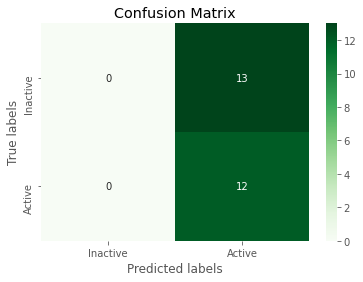

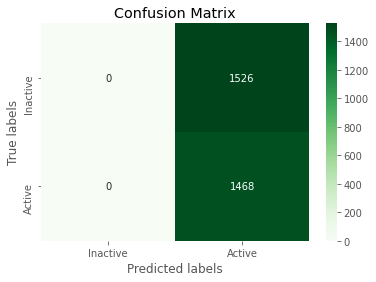

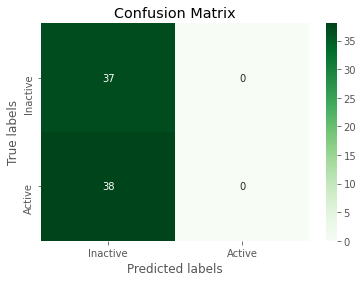

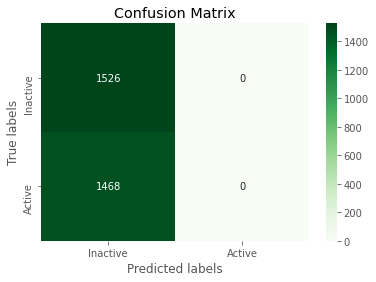

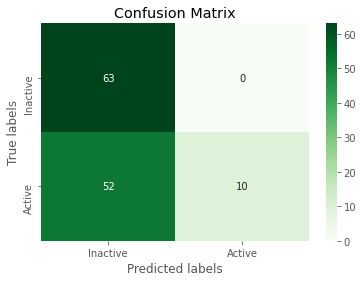

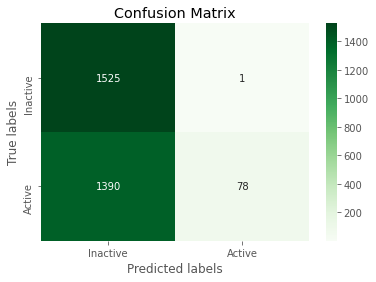

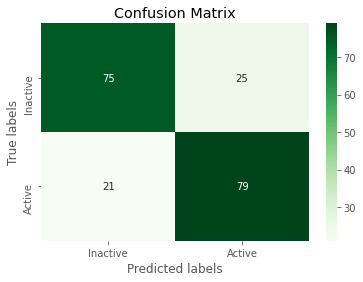

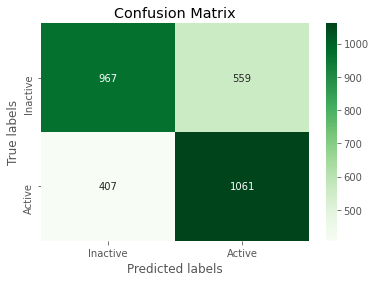

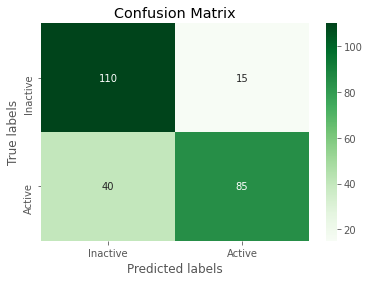

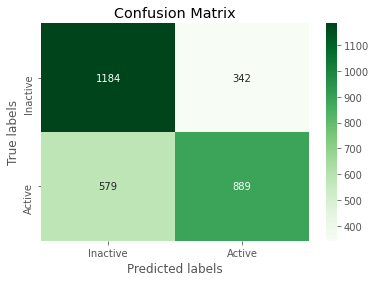

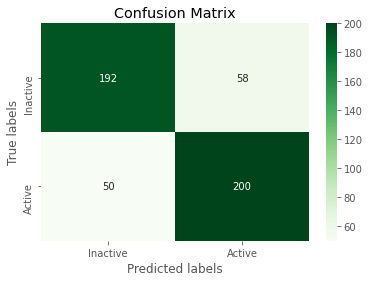

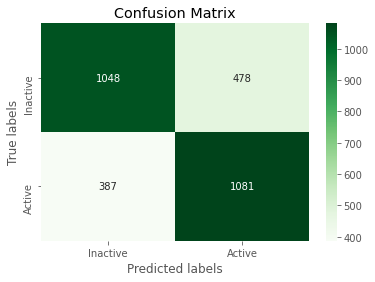

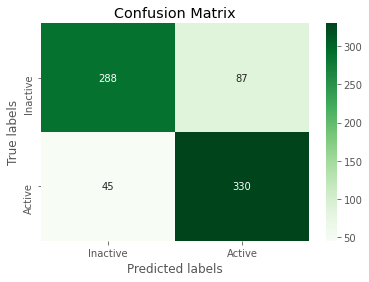

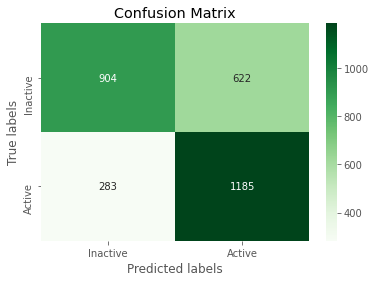

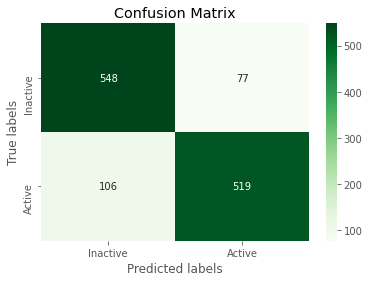

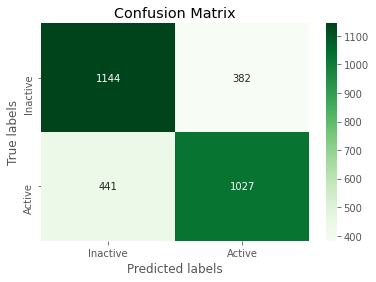

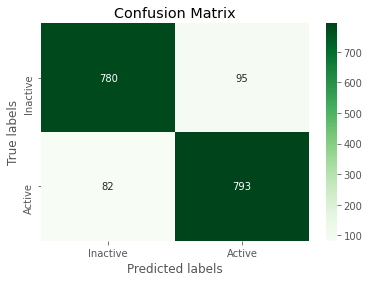

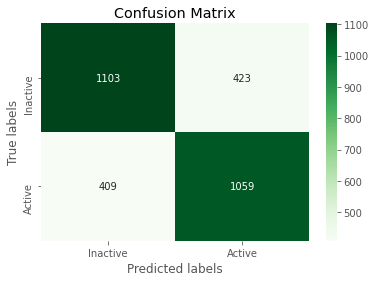

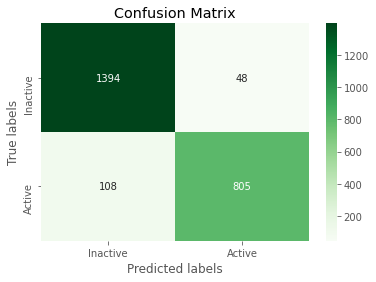

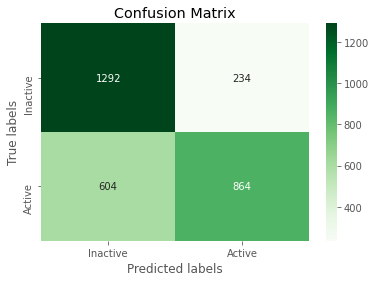

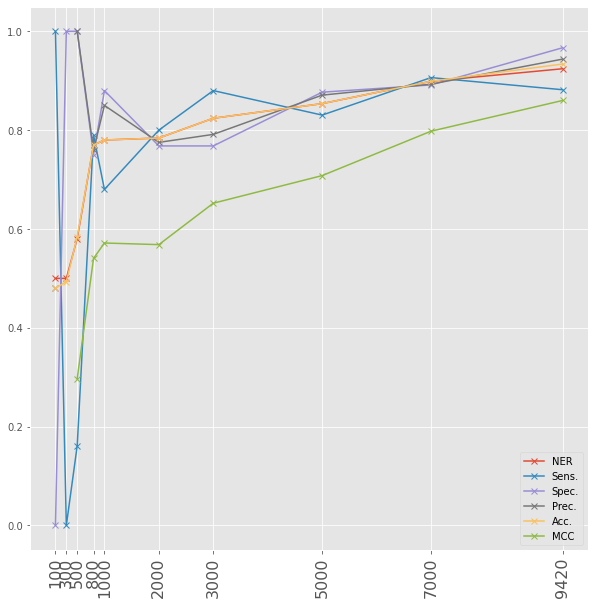

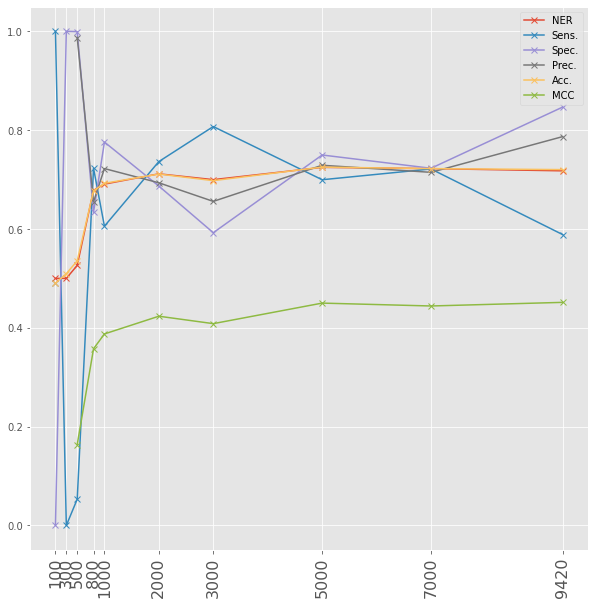

In [33]:
results_test = np.array(results_test)
results_validation = np.array(results_validation)
labels = ["NER", "Sens.", "Spec.", "Prec.", "Acc.", "MCC"]
f, ax = plt.subplots(figsize=(10,10))
lines = ax.plot(sizes, results_test, "x-")
ax.legend(lines, labels)
ax.set_xticks(ticks=sizes)
ax.set_xticklabels(sizes, rotation=90, fontsize=16);
f.savefig(os.path.join(plots_path_balanced, "metrics_test_evolution_balanced_3a4.png"), bbox_inches="tight", dpi=300)
f, ax = plt.subplots(figsize=(10,10))
lines = ax.plot(sizes, results_validation, "x-")
ax.legend(lines, labels)
ax.set_xticks(ticks=sizes)
ax.set_xticklabels(sizes, rotation=90, fontsize=16);
f.savefig(os.path.join(plots_path_balanced, "metrics_validation_evolution_balanced_3a4.png"), bbox_inches="tight", dpi=300)